In [1]:
from glob import glob
import sys
import getpass
import os
from os.path import join, dirname, getsize
import pickle
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.stats.multitest
# from statsmodels.sandbox.stats.multicomp import multipletests

import nilearn

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import LinearSVC

# import mydef as my Class correction for projects
import mydef

/home/sungbeenpark/anaconda3/envs/sampark/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
GA = mydef.GA()

OS : linux
Google Drive is detected!
Git directory is detected!


## 1. ROI list

In [3]:
## initalizing
GA.roi_imgs = {}

- Localizer

In [4]:
suffix = 'all_localizers'
path_list = sorted(glob(join(GA.dir_mask,'localizer','n200_*.nii')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    GA.roi_imgs[roi] = nilearn.image.load_img(path)
GA.roi_imgs

{'n200_c1-1_L_M1': <nibabel.nifti1.Nifti1Image at 0x7f9bf45db5b0>,
 'n200_c1-2_L_S1': <nibabel.nifti1.Nifti1Image at 0x7f9bf4566280>,
 'n200_c1_L_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7f9a7282d160>,
 'n200_c1_R_SPL': <nibabel.nifti1.Nifti1Image at 0x7f9a7282d4c0>,
 'n200_c2_R_CerebellumIV-V': <nibabel.nifti1.Nifti1Image at 0x7f9a7282d760>,
 'n200_c2_R_MFG': <nibabel.nifti1.Nifti1Image at 0x7f9a7282da60>,
 'n200_c3_R_MTG': <nibabel.nifti1.Nifti1Image at 0x7f9a7282dbb0>,
 'n200_c3_R_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7f9a7282d2e0>,
 'n200_c4_L_IFG': <nibabel.nifti1.Nifti1Image at 0x7f9a72830310>,
 'n200_c4_L_Putamen': <nibabel.nifti1.Nifti1Image at 0x7f9a728305e0>,
 'n200_c5_L_SPL': <nibabel.nifti1.Nifti1Image at 0x7f9a728308e0>,
 'n200_c5_R_SMA': <nibabel.nifti1.Nifti1Image at 0x7f9a72830b80>,
 'n200_c6_R_CerebellumVIIIb': <nibabel.nifti1.Nifti1Image at 0x7f9a72830eb0>,
 'n200_c6_R_MFG': <nibabel.nifti1.Nifti1Image at 0x7f9a728370a0>,
 'n200_c7_L_Thalamus': <nibabel

0

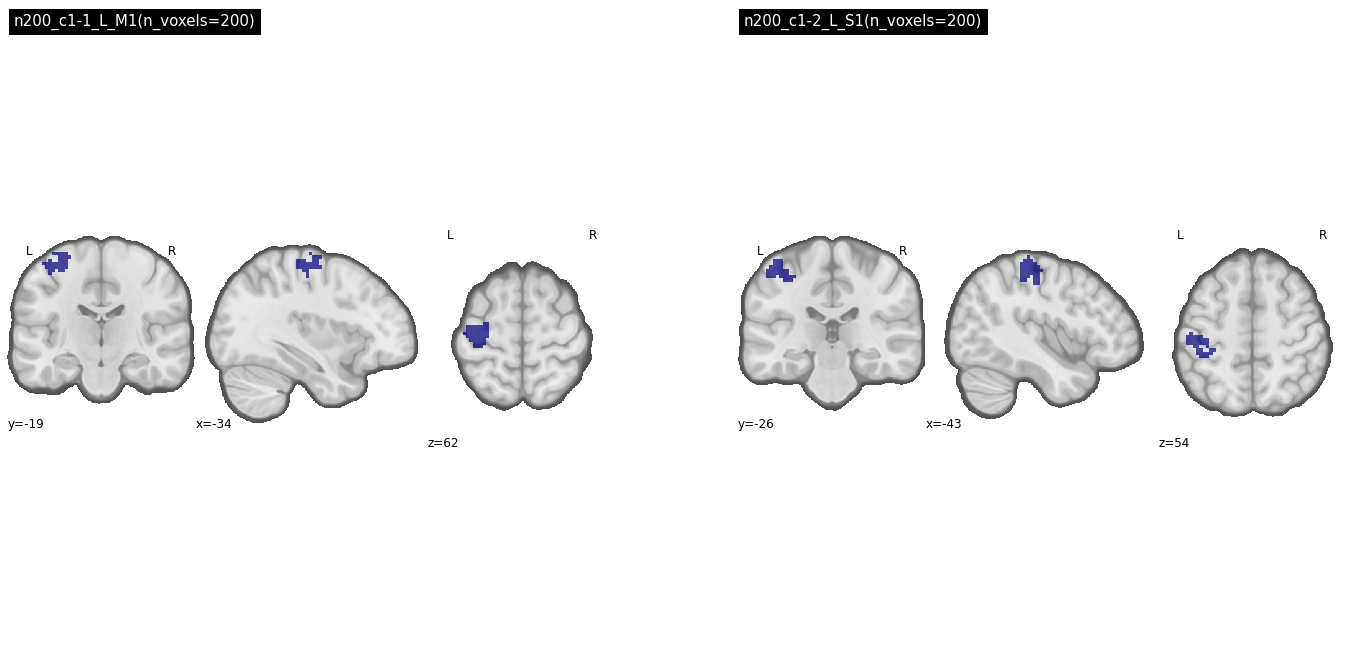

In [7]:
GA.plot_rois()

## 2. Loading result

In [5]:
GA.show_pkl_list(path=GA.dir_script, word='decacc.%s'%suffix)

,name,identity
0,./20210812_decacc.all_localizers.pkl,a


In [6]:
GA.make_df_score(fname='./20210812_decacc.%s.pkl'%suffix)

,subj,stage,ROI,mean_accuracy
0,01,early_practice,n200_c1-1_L_M1,0.368056
1,01,early_practice,n200_c1-2_L_S1,0.357639
2,01,early_practice,n200_c1_L_Postcentral,0.378472
3,01,early_practice,n200_c1_R_SPL,0.388889
4,01,early_practice,n200_c2_R_CerebellumIV-V,0.260417
...,...,...,...,...
2155,44,late_unpractice,n200_c6_R_MFG,0.284722
2156,44,late_unpractice,n200_c7_L_Thalamus,0.236111
2157,44,late_unpractice,n200_c7_R_MFG2,0.298611
2158,44,late_unpractice,n200_c8_R_IFG,0.329861


In [7]:
GA.df_score = GA.df_score[GA.df_score.ROI=='n200_c1_L_Postcentral']

## 3. two-way repeated measurement ANOVA

In [8]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [9]:
stage = []
mapping = []
for string in list(GA.df_score.stage):
    [s,m] = string.split('_')
    stage.append(s)
    mapping.append(m)

In [10]:
temp = pd.DataFrame()

In [11]:
temp['subj'] = GA.df_score.subj
temp['stage'] = stage # 독립변수 1
temp['mapping'] = mapping # 독립변수 2
temp['ROI'] = GA.df_score.ROI
temp['mean_accuracy'] = GA.df_score.mean_accuracy # 종속변수

In [12]:
temp

,subj,stage,mapping,ROI,mean_accuracy
2,01,early,practice,n200_c1_L_Postcentral,0.378472
20,01,early,unpractice,n200_c1_L_Postcentral,0.413194
38,01,late,practice,n200_c1_L_Postcentral,0.392361
56,01,late,unpractice,n200_c1_L_Postcentral,0.406250
74,02,early,practice,n200_c1_L_Postcentral,0.302083
...,...,...,...,...,...
2072,42,late,unpractice,n200_c1_L_Postcentral,0.208333
2090,44,early,practice,n200_c1_L_Postcentral,0.361111
2108,44,early,unpractice,n200_c1_L_Postcentral,0.375000
2126,44,late,practice,n200_c1_L_Postcentral,0.562500


In [13]:
# from statsmodels.graphics.factorplots import interaction_plot

# fig = interaction_plot(temp.stage, temp.mapping, temp.mean_accuracy,
#              colors=['red','blue'], markers=['D','^'], ms=10)

1. 균형설계자료인지 확인

In [14]:
temp.groupby('stage').agg(len)

,subj,mapping,ROI,mean_accuracy
stage,,,,
early,60,60,60,60
late,60,60,60,60


In [15]:
temp.groupby('mapping').agg(len)

,subj,stage,ROI,mean_accuracy
mapping,,,,
practice,60,60,60,60
unpractice,60,60,60,60


In [16]:
temp.groupby(['stage','mapping']).agg(len)

subj  ROI  mean_accuracy
stage mapping                             
early practice      30   30             30
      unpractice    30   30             30
late  practice      30   30             30
      unpractice    30   30             30

각 요인들로 구분한 집단별 표본수는 모두 동일

모든 집단별 표본수가 동일하므로, 균형설계자료 이원분산분석 실시

In [17]:
formula = 'mean_accuracy ~ C(stage) * C(mapping)'
# formula = 'mean_accuracy ~ C(stage) + C(mapping) + C(stage):C(mapping)'
model = ols(formula, temp).fit()
temp = anova_lm(model)

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          mean_accuracy   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     7.944
Date:                Fri, 13 Aug 2021   Prob (F-statistic):           7.30e-05
Time:                        09:09:42   Log-Likelihood:                 152.29
No. Observations:                 120   AIC:                            -296.6
Df Residuals:                     116   BIC:                            -285.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     0.3295      0.013     26.089      0.000       0.304       0.355
C(stage)[T.late]                              0.0862      0.018      4.827      0.000       0.051       0.122
C(mapping)[T.unpractice]                      0.0319      0.018      1.788      0.076      -0.003       0.067
C(stage)[T.late]:C(mapping)[T.unpractice]    -0.0777      0.025     -3.074      0.003      -0.128      -0.028
==============================================================================
Omnibus:                        6.074   Durbin-Watson:                   1.549
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                5.589
Skew:                           0.506   Prob(JB):                       0.0612
Kurtosis:                       3.309   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As a Psychologist, most of the journals we publish in requires to report effect sizes. Common software, such as SPSS has eta squared as output. However, eta squared is an overestimation of the effect. To get a less biased effect size measure we can use omega squared. The following two functions add eta squared and omega squared to the above DataFrame that contains the ANOVA table.

In [19]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

In [20]:
eta_squared(temp)
omega_squared(temp)

,df,sum_sq,mean_sq,F,PR(>F),eta_sq,omega_sq
C(stage),1.0,0.067391,0.067391,14.081427,0.000275,0.100703,0.092888
C(mapping),1.0,0.001423,0.001423,0.297285,0.586636,0.002126,-0.004990
C(stage):C(mapping),1.0,0.045235,0.045235,9.452004,0.002630,0.067596,0.060015
Residual,116.0,0.555153,0.004786,NaN,NaN,NaN,NaN


stage: F(1, 116) = 0.000275, p < 0.005로 유의미. 즉 stage의 수준에 따라 평균에 차이가 난다고 볼 수 있음

mapping: F(1, 116) = 0.297, p > 0.05로 유의미하지 않음. 즉 mapping의 수준에 따라 평균에 차이가 난다고 볼 수 없음

stage:mapping: F(1, 116) = 9.45, p < 0.005로 유의미. 상호작용 효과 있음

example

In [23]:
from statsmodels import api
moore = api.datasets.get_rdataset("Moore", "carData", cache=True) # load data
data = moore.data
data = data.rename(columns={"partner.status":"partner_status"}) # make name pythonic

moore_lm = ols('conformity ~ C(fcategory, Sum)*C(partner_status, Sum)', data=data).fit()

table = anova_lm(moore_lm, typ=2) # Type 2 ANOVA DataFrame
print(table)

                                              sum_sq    df          F  \
C(fcategory, Sum)                          11.614700   2.0   0.276958   
C(partner_status, Sum)                    212.213778   1.0  10.120692   
C(fcategory, Sum):C(partner_status, Sum)  175.488928   2.0   4.184623   
Residual                                  817.763961  39.0        NaN   

                                            PR(>F)  
C(fcategory, Sum)                         0.759564  
C(partner_status, Sum)                    0.002874  
C(fcategory, Sum):C(partner_status, Sum)  0.022572  
Residual                                       NaN  


In [24]:
data

,partner_status,conformity,fcategory,fscore
0,low,8,low,37
1,low,4,high,57
2,low,8,high,65
3,low,7,low,20
4,low,10,low,36
5,low,6,low,18
6,low,12,medium,51
7,low,4,medium,44
8,low,13,low,31
9,low,12,low,36


## ?. Loading ANOVA data

In [7]:
gg = 'GA'
anova = nilearn.image.load_img(join(GA.dir_stats,'ANOVA','ANOVA.%s.MO.shortdur.4target+tlrc.nii.gz'%gg))

In [7]:
print(anova.shape)
# nilearn.plotting.plot_glass_brain(anova)

(72, 85, 72, 1, 42)


In [8]:
type(anova)

nibabel.nifti1.Nifti1Image

In [15]:
anova.header

1. M1

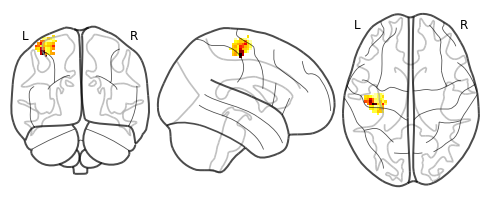

In [12]:
masked_anova = nilearn.image.math_img(
    img1=anova, img2=GA.roi_imgs['n200_c1-1_L_M1']
    , formula='img1 * img2'
)
nilearn.plotting.plot_glass_brain(masked_anova)

2. S1

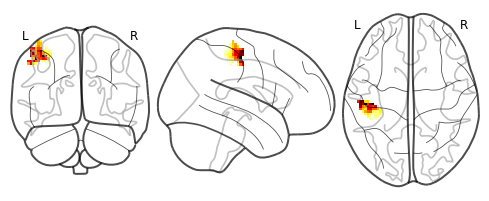

In [13]:
masked_anova = nilearn.image.math_img(
    img1=anova, img2=GA.roi_imgs['n200_c1-2_L_S1']
    , formula='img1 * img2'
)
nilearn.plotting.plot_glass_brain(masked_anova)